In [33]:
### Loading Credentials from local file; 
### this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 4:  Example Case - History of Physiology</font>

# Defining the Physiology Graph

Search for "hysiolog" as substring for Physiology to retrieve every possible string containing.


In [34]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (t:TopicTerm)
WHERE t.Name CONTAINS "hysiolog"
RETURN DISTINCT(t.Name) as term
"""

with driver.session() as session:
    all_physiology_terms = session.run(query).data()
    
all_physiology_terms

[{'term': 'Arbeitsphysiologie'},
 {'term': 'Neurophysiologie'},
 {'term': 'Pathophysiologie'},
 {'term': 'Pflanzenphysiologie'},
 {'term': 'Physiologie'},
 {'term': 'Sinnesphysiologie'},
 {'term': 'Tierphysiologie'},
 {'term': 'Physiologische Chemie'},
 {'term': 'Physiologische Psychologie'},
 {'term': 'Sprachphysiologie'},
 {'term': 'Sportphysiologie'},
 {'term': 'Leistungsphysiologie'},
 {'term': 'Physiologische Psychiatrie'},
 {'term': 'Elektrophysiologie'},
 {'term': 'Altersphysiologie'},
 {'term': 'Bewegungsphysiologie'},
 {'term': 'Entwicklungsphysiologie'},
 {'term': 'Ernährungsphysiologie'},
 {'term': 'Ertragsphysiologie'},
 {'term': 'Histophysiologie'},
 {'term': 'Höhenphysiologie'},
 {'term': 'Nacherntephysiologie'},
 {'term': 'Physiologische Optik'},
 {'term': 'Physiologische Uhr'},
 {'term': 'Psychophysiologische Diagnostik'},
 {'term': 'Stoffwechselphysiologie'},
 {'term': 'Vegetative Physiologie'},
 {'term': 'Vergleichende Neurophysiologie'},
 {'term': 'Vergleichende Ph

Let's see whether every topic term also has people connected to them. 

In [35]:
from helper_functions.helper_fun import to_nx_graph

query = """
MATCH (t:TopicTerm)-[r]-(n:PerName)
WHERE t.Name CONTAINS "hysiolog"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

Check which topic terms aren't present in query result:

In [36]:
import numpy as np

relevant_topics = []
for node in list(G.nodes):
    if G.nodes[node]["type"] == "TopicTerm":
        relevant_topics.append((G.nodes[node]["label"]))

np.setdiff1d([d["term"] for d in all_physiology_terms], relevant_topics)

array(['Altersphysiologie', 'Bewegungsphysiologie',
       'Elektrophysiologische Untersuchung', 'Ertragsphysiologie',
       'Experimentelle Physiologie', 'Histophysiologie',
       'Ignaz-L.-Lieben-Preis für Physik, Chemie und Physiologie',
       'Muskelphysiologie', 'Physiologische Optik', 'Physiologische Uhr',
       'Psychophysiologische Diagnostik', 'Reizphysiologie',
       'Sprachphysiologie', 'Tauchphysiologie', 'Umweltphysiologie',
       'Vergleichende Neurophysiologie', 'Vergleichende Physiologie',
       'Zellphysiologie'], dtype='<U57')

@todo add colors to network below by node type

In [37]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

nt = Network('750px', '100%', notebook=True, directed = True)
nt.from_nx(G)
nt.set_edge_smooth("dynamic")
#nt.show('./html_networks/physiological_net.html')

## Retrieving the Network

In [38]:
%%time

from helper_functions.helper_fun import to_nx_graph

query = """
MATCH (t:TopicTerm)--(n)
WHERE t.Name CONTAINS "hysiolog" AND (n:PerName)
WITH DISTINCT [x in collect(t)+collect(n)|id(x)] as collectedIds 
MATCH (n)-[rel1:RelationToPerName|SocialRelation|RelationToResource|RelationToGeoName|RelationCorpName|RelationToUniTitle*0..1]-(n2)
WHERE id(n) in collectedIds 
RETURN n, n2, rel1
"""


driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

CPU times: user 2min 15s, sys: 4.87 s, total: 2min 20s
Wall time: 2min 21s


In [39]:
import pickle

filename = 'physiology_graph'
outfile = open(filename,'wb')

pickle.dump(G,outfile)
outfile.close()

In [40]:
import pickle

with open('physiology_graph', 'rb') as f:
    G = pickle.load(f)

## Descriptive Metrics

In [41]:
print("Number of Nodes: ", G.number_of_nodes())
print("Number of Edges: ", G.number_of_edges())

Number of Nodes:  49969
Number of Edges:  64974


In [76]:
types_list = list(set([y["type"] for x,y in G.nodes(data=True)]))
person_nodes = [x for x,y in G.nodes(data=True) if y['type']=="PerName"]
resources_and_works_nodes = [x for x,y in G.nodes(data=True) if y['type'] in ["Resource", "UniTitle"]]
corps_nodes = [x for x,y in G.nodes(data=True) if y['type']=="CorpName"]
geo_nodes = [x for x,y in G.nodes(data=True) if y['type']=="GeoName"]
topicterm_nodes = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

print("Node types in Graph:", type_list)
print("Number of Persons in Graph: ", len(person_nodes))
print("Number of Resources and Works in Graph: ", len(resources_and_works_nodes))
print("Number of Corporations in Graph: ", len(corps_nodes))
print("Number of GeoNames in Graph:", len(geo_nodes))
print("")
print("## Topic Terms in Graph: ## ")
for node in topicterm_nodes:
    print(G.nodes(data=True)[node]["label"])

Node types in Graph: ['GeoName', 'CorpName', 'TopicTerm', 'PerName', 'Resource', 'MeetName', 'UniTitle']
Number of Persons in Graph:  13779
Number of Resources and Works in Graph:  34306
Number of Corporations in Graph:  1270
Number of GeoNames in Graph: 560

## Topic Terms in Graph: ## 
Arbeitsphysiologie
Neurophysiologie
Pathophysiologie
Pflanzenphysiologie
Physiologie
Sinnesphysiologie
Tierphysiologie
Physiologische Chemie
Physiologische Psychologie
Sportphysiologie
Leistungsphysiologie
Physiologische Psychiatrie
Elektrophysiologie
Entwicklungsphysiologie
Ernährungsphysiologie
Höhenphysiologie
Nacherntephysiologie
Stoffwechselphysiologie
Vegetative Physiologie
Verhaltensphysiologie
Physiologe
Physiologin
Physiologische Akustik
Pflanzenphysiologe
Pflanzenphysiologin
Bernoulli-Balken
Bathybius haeckelii


Let's add a color attribute to the nodes based on the node types. This way visualizations of the network will be more informative to us. 

In [115]:
type_list = list([y["type"] for x,y in G.nodes(data=True)])

color_map = {"GeoName": "green",
             "CorpName": "red",
             "TopicTerm": "yellow",
             "PerName": "blue",  
             "Resource": "purple", 
             "MeetName": "orange", 
             "UniTitle": "pink"}

# We generate a dictionary again to map the respective type to the correct color
color_dict = dict(zip(list(G.nodes), [color_map.get(item, item) for item in type_list]))

# And finally we add the color information as a new attribute to the graph object
nx.set_node_attributes(G, color_dict, "color")

### Check Density and Connectedness of Network

Since our network is pretty large, it is a bit complicated to investigate the network visually from within this notebook. This is why we start investigating the network with some further descriptive assessments. 


Let's start with the *density* of the network. The *Network density* measures how many relationships between nodes exist in relation to how many relations are possible. Graph density for an undirected Graph is calculated as follows:

\begin{align}
x & = \frac{m}{n(n-1)/2}
\end{align}

$n$ is the number of nodes and $m$ is the number of relationships in the graph. By calculating $n(n-1)/2$ we get the number of possible relationships in the graph. Basically we divide the number of edges by the number of possible edges and so we get the *density*. 
When every node is connected to every other node in the network, the density is 1. On the other hand, when there are no relationships between any nodes, the density is 0. 

We calculate the density to see how connected our graph is. 

The formula for a directed graph is slightly different from the formula presented above. Click [here](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html?highlight=density) for more details.

In [79]:
import networkx as nx

nx.density(G)

5.204475574087443e-05

As we can see, the density of our network is very low. This means that the nodes in our network are not very connected to each other. This could mean, that the graph consists of many isolated nodes or many little *components*. 

Let's at first check whether this assumption is true. To do so, we can assess the *connectivity* of the graph. A graph is considered to be connected, as long as there is a possibility to traverse from every node in the graph to any other node. Or in other words: A graph is disconnected, when it consists of isolated subgraphs, also called *components*.

We can use the `is_connected()` method of the networkx library to do the connectivity check. [Here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_connected.html#networkx.algorithms.components.is_connected) you can find the documentation of the function. 



In [80]:
nx.is_connected(G)

False

Apparently the physiology graph is not fully connected and therefore there are isolated components in the graph. So let's try to understand, what these components are.

**Components** 

Whenever you work with a network taken from the real world, it's quite common that the network is not fully connected. 
As we just found out, the physiology network also seems to consist of isolated "islands of nodes". Let's find out how many components our network has and how big they are. 

We will use some of the components algorithm the `networkx` library provides. [Here](https://networkx.org/documentation/stable/reference/algorithms/component.html) you can find an overview of all components related algorithms available. 

We can use the method `number_connected_components()` to recieve the number of components in our graph.

In [81]:
nx.number_connected_components(G)

685

There are nearly 700 components present in the graph. Let's investigate them further.

By using the method `connected_components()` we can get a list containing the nodes present in each of the 685 components.  

In [118]:
# retrieve a list of all components and the associated nodes
components = nx.connected_components(G)

# now we create a list containg the information about each component size (number of nodes)
component_size_list = [len(component) for component in components]

# let's print some summary details
print("number of unique component sizes (number of nodes):", len(set(component_size_list)))
print("maximum component length:", max(set(component_size_list)))
print("minimum component length:", min(set(component_size_list)))

number of unique component sizes (number of nodes): 24
maximum component length: 48175
minimum component length: 1


Alright, as we can see from the output above, there are 24 distinct component sizes. This means that each of the 685 components takes one of 24 different sizes. The sizes of the components have a range from 1 node (a single node without any relationships) to 48175 nodes. 

Let's check the distribution of the components sizes next.

<AxesSubplot:>

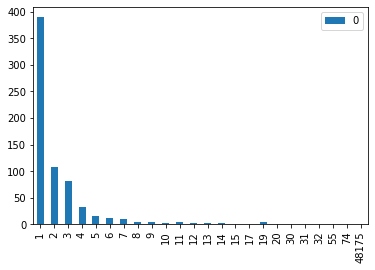

In [119]:
import numpy as np
import pandas as pd

values, counts = np.unique(component_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

More than 50% of the components in our graph are isolated nodes. There are quite some components with just a few nodes in them. But there is this one huge cluster with 48175 nodes. 

Let's create a subgraph of the largest component. As we want to explore the network of physiologists it might be most interesting to investigate the largest component and not the smaller ones.

We can use the method `subgraph()` to extract the graph of the largest component. We just need to pass in a list of nodes we want to include in the new subgraph. Click [here](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html) for the documentation of the method.

In [120]:
# at first we extract the the largest component

components = nx.connected_components(G)
largest_component = max([component for component in components], key = len)
print(len(largest_component))

largest_component_graph = G.subgraph(largest_component)

48175


Now we have our subgraph and we know that is is a connected graph now. Let's check if this assumption is true:

In [93]:
nx.is_connected(largest_component_graph)

True

Perfect, so let's go on investigating this subgraph now.

# Investigating the Persons

## Centrality Investigation

At first we are going to investigate the centrality of the physiology network. By assessing the centrality we actually calculate the importance of the nodes. 

 

### Degree Centrality

In [95]:
degrees = nx.degree_centrality(largest_component_graph)

In [96]:
from operator import itemgetter

degrees_sorted = sorted(degrees.items(), key = itemgetter(1), reverse = True)
degrees_filtered = [item for item in degrees_sorted if item[0] in person_nodes]
top_degrees = degrees_filtered[:10]

In [97]:
for i in top_degrees: 
    degree = degrees[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Degree Centrality:", i[1])

Name: Wundt, Wilhelm | Degree Centrality: 0.17951592145140532
Name: Oken, Lorenz | Degree Centrality: 0.05432390916261884
Name: Baer, Karl Ernst von | Degree Centrality: 0.05160459999169676
Name: Pirson, André | Degree Centrality: 0.04523186781251297
Name: Eccles, John C. | Degree Centrality: 0.04276165566488147
Name: Haller, Albrecht von | Degree Centrality: 0.03686635944700461
Name: Cohn, Jonas | Degree Centrality: 0.0300369493917881
Name: Du Bois- Reymond, Emil Heinrich | Degree Centrality: 0.024619089135218167
Name: Euler, Leonhard | Degree Centrality: 0.024598331049943953
Name: Helmholtz, Hermann von | Degree Centrality: 0.024515298708847093


In [49]:
largest_component_graph.degree(top_degrees[0][0])

8648

### Eigenvector Centrality

In [50]:
eigenvectors = nx.eigenvector_centrality_numpy(largest_component_graph)

In [51]:
from operator import itemgetter

eigenvectors_sorted = sorted(eigenvectors.items(), key = itemgetter(1), reverse = True)
eigenvectors_filtered = [item for item in eigenvectors_sorted if item[0] in person_nodes]
top_eigenvectors = eigenvectors_filtered[:10]

In [52]:
for i in top_eigenvectors: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: Wundt, Wilhelm | Eigenvector Centrality: 0.7051314322504603
Name: Helmholtz, Hermann von | Eigenvector Centrality: 0.040611934429522996
Name: Du Bois- Reymond, Emil Heinrich | Eigenvector Centrality: 0.02564805285503684
Name: Lotze, Hermann | Eigenvector Centrality: 0.024399719180380978
Name: Cohn, Jonas | Eigenvector Centrality: 0.021747254210137745
Name: Oken, Lorenz | Eigenvector Centrality: 0.019706973925948886
Name: Weber, Ernst Heinrich | Eigenvector Centrality: 0.016869098256312033
Name: Haller, Albrecht von | Eigenvector Centrality: 0.0165399007601484
Name: Müller, Johannes | Eigenvector Centrality: 0.016263981426262217
Name: Preyer, William T. | Eigenvector Centrality: 0.01435665781945855


### PageRank

In [32]:
pageranks = nx.pagerank(largest_component_graph)

In [33]:
from operator import itemgetter

pageranks_sorted = sorted(pageranks.items(), key = itemgetter(1), reverse = True)
pageranks_filtered = [item for item in pageranks_sorted if item[0] in person_nodes]
top_pageranks = pageranks_filtered[:10]

In [34]:
for i in top_pageranks: 
    degree = pageranks[i[0]] 
    print("id: ", i[0], "Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| PageRank Centrality:", i[1])

id:  2925003 Name: Wundt, Wilhelm | PageRank Centrality: 0.07322503088959763
id:  2920435 Name: Oken, Lorenz | PageRank Centrality: 0.022486114985672583
id:  2912081 Name: Baer, Karl Ernst von | PageRank Centrality: 0.020837094436932282
id:  2895349 Name: Pirson, André | PageRank Centrality: 0.01812888645338315
id:  2915992 Name: Haller, Albrecht von | PageRank Centrality: 0.015014881758535388
id:  2928379 Name: Cohn, Jonas | PageRank Centrality: 0.012814816928099465
id:  2946338 Name: Eccles, John C. | PageRank Centrality: 0.010695691527821157
id:  2914627 Name: Euler, Leonhard | PageRank Centrality: 0.01051764882987141
id:  2914257 Name: Du Bois- Reymond, Emil Heinrich | PageRank Centrality: 0.009388386350686334
id:  2941800 Name: Sömmerring, Samuel Thomas von | PageRank Centrality: 0.009027728792718077


### Centrality of Women

We can apply another filter to our 

## Investigating Cliques

In [121]:
# retrieve a list of all cliques and the associated nodes
cliques = nx.find_cliques(largest_component_graph)

# now we create a list containg the information about each clique size (number of nodes)
clique_size_list = [len(clique) for clique in cliques]

# let's print some summary details
print("number of unique clique sizes (number of nodes):", len(set(clique_size_list)))
print("maximum clique size:", max(set(clique_size_list)))
print("minimum clique size:", min(set(clique_size_list)))

number of unique clique sizes (number of nodes): 21
maximum clique size: 27
minimum clique size: 2


<AxesSubplot:>

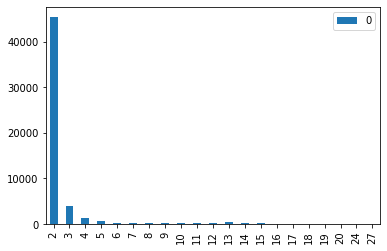

In [122]:
import numpy as np
import pandas as pd

values, counts = np.unique(clique_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

In [123]:
cliques = nx.find_cliques(largest_component_graph)
relevant_cliques = [clique for clique in cliques if len(clique) >=10]
clique_nodes = set(n for clique in relevant_cliques for n in clique)
cliques_subgraph = G.subgraph(clique_nodes)

In [124]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

nt = Network('500px', '100%', notebook=True)
nt.from_nx(cliques_subgraph)
nt.set_edge_smooth("dynamic")
#nt.toggle_physics(False)
nt.force_atlas_2based(gravity = -55)
nt.show('./html_networks/cliques_network.html')

## Community Detection

In [70]:
import community as community_louvain

# compute the best partition
partition = community_louvain.best_partition(largest_component_graph)
partition

{5046970: 0,
 1498320: 0,
 1497822: 0,
 14948439: 0,
 22459300: 0,
 5046966: 0,
 23581357: 0,
 23654879: 0,
 23807140: 0,
 26106203: 0,
 1144409: 0,
 26582559: 0,
 27648652: 0,
 29488170: 0,
 42308821: 0,
 2638684: 1,
 11618702: 1,
 11618344: 1,
 11617864: 1,
 11618781: 1,
 11617913: 1,
 11618707: 1,
 11617912: 1,
 11618710: 1,
 11618793: 1,
 11618511: 1,
 11618531: 1,
 11618782: 1,
 11617942: 1,
 11617865: 1,
 11618887: 1,
 11617914: 1,
 11618708: 1,
 11618532: 1,
 11617885: 1,
 11617878: 1,
 11618626: 1,
 11617930: 1,
 11617863: 1,
 11618534: 1,
 11617941: 1,
 11617911: 1,
 11617884: 1,
 11618373: 1,
 14615288: 1,
 14829033: 1,
 16885946: 1,
 38775335: 1,
 38776843: 1,
 5248332: 1,
 2942960: 1,
 89154: 1,
 2041899: 1,
 6296338: 1,
 5176002: 1,
 5175262: 1,
 2946338: 1,
 2922833: 1,
 2625027: 1,
 5175185: 1,
 3147114: 1,
 5175248: 1,
 5181184: 1,
 14562: 1,
 4240702: 1,
 3389912: 1,
 5230419: 1,
 5181352: 1,
 5239552: 1,
 5181195: 1,
 63720: 1,
 5201437: 1,
 3674325: 1,
 6240293: 1,
 

# Investigating Corporations

# Investigating Resources and Works

# Investigating predefined set of Physiologists

* Gustav Fritsch (DE-588)115568808
* Eduard Hitzig (DE-588)116917423
* Hermann Munk (DE-588)117185930
* Nathan Zuntz (DE-588)118896202
* Friedrich Goltz (DE-588)116764694
* Adolf Fick (DE-588)118800000
* Jacques Loeb (DE-588)119133628

In [ ]:
physiologists = ["(DE-588)115568808", "(DE-588)116917423", "(DE-588)117185930", "(DE-588)118896202", 
                 "(DE-588)116764694", "(DE-588)118800000", "(DE-588)119133628"]

# Bibliography

Scifo, E. (2020). Hands-On Graph Analytics with Neo4j: Perform graph processing and visualization techniques using connected data across your enterprise. Birmingham, England: Packt Publishing.